In [1]:
# Compare Cls with the ones of William

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import os
import sys
import copy
import itertools
from scipy.linalg import block_diag
import hashlib

import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
from camb.fisher.cachers import cacher_pk, cacher_mem, cacher_dict_mem
from camb.fisher.utils import enumerate_progress, is_pos_def, cov_to_corr, set_mpl
from camb import fisher

from getdist import plots
from getdist.gaussian_mixtures import GaussianND

from os.path import join as opj

print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.6 installed at /Users/louis/Code/CAMBfork/camb


In [3]:
# set_mpl()
import matplotlib.pyplot as plt
set_mpl()

In [4]:
from camb.fisher.cosmo import ffp10_plancklens
from camb.fisher.utils import latex_names as latex

In [5]:
params_cosmo = ['logA', 'ns', 'cosmomc_theta', 'omch2', 'ombh2']

In [6]:
fiducials = ffp10_plancklens

In [7]:
pars = camb.CAMBparams()

if 'H0' in params_cosmo:
    pars.set_cosmology(H0=fiducials['H0'], ombh2=fiducials['ombh2'], omch2=fiducials['omch2'], mnu=fiducials['mnu'], omk=fiducials['omk'], tau=fiducials['tau'])
elif 'cosmomc_theta' in params_cosmo:
    pars.set_cosmology(cosmomc_theta=fiducials['cosmomc_theta'], ombh2=fiducials['ombh2'], omch2=fiducials['omch2'], mnu=fiducials['mnu'], omk=fiducials['omk'], tau=fiducials['tau'])

pars.InitPower.set_params(As=fiducials['As'], ns=fiducials['ns'], r=0)




class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.9636852
 nrun = 0.0
 nrunrun = 0.0
 nt = 0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2.119631e-09
 At = 1.0
 

In [8]:
# Follows Matthewson et al Fig 1.

zobs = 0.9225
sigz = 0.02
bg_z = lambda z  : 0.79 + 0.68*z 

nofz = lambda z : -1494.07*z**2 + 2598.21*z + 717.09


zs = np.arange(0., 3, 1e-4)


window_g = np.exp(-(zs - zobs) ** 2 / (2 * sigz ** 2)) / (np.sqrt(2 * np.pi) * sigz)
window =  window_g * nofz(zs)
window = window / np.trapz(window, zs)
    
# sources = [GaussianSourceWindow(redshift=zobs, source_type='counts', bias=bg_z(zobs), sigma=sigz, dlog10Ndm=0.),  \
#         GaussianSourceWindow(redshift=zobs, source_type='arf', bias=bg_z(zobs), sigma=sigz, dlog10Ndm=0.) ]

sources = [SplinedSourceWindow(z=zs,source_type='counts', W=window, bias_z = bg_z(zobs)*np.ones_like(zs)), 
          SplinedSourceWindow(z=zs, source_type='arf', W=window, bias_z = bg_z(zobs)*np.ones_like(zs))]


In [9]:
set_mpl()

(0.8, 1.1)

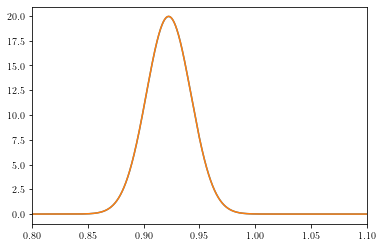

In [10]:
plt.plot(zs, window_g)
plt.plot(zs, window)

plt.xlim(0.8, 1.1)

In [11]:
lmax = 1000

pars.set_for_lmax(lmax, lens_potential_accuracy=0)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = False
pars.Want_CMB_lensing = False

#NonLinear_both or NonLinear_lens will use non-linear corrections
# pars.NonLinear = model.NonLinear_both

pars.SourceWindows = sources

pars.SourceTerms.limber_windows = False
pars.SourceTerms.limber_phi_lmin = 100

cls = {}

In [12]:
pars.SourceTerms.counts_density = True 
pars.SourceTerms.counts_redshift = True  
pars.SourceTerms.counts_velocity = True
pars.SourceTerms.counts_lensing = True  
pars.SourceTerms.counts_radial = True  
pars.SourceTerms.counts_timedelay = True
pars.SourceTerms.counts_ISW = True
pars.SourceTerms.counts_potential = True
pars.SourceTerms.counts_evolve = True


results = camb.get_results(pars)
cls['tot'] = results.get_source_cls_dict(raw_cl=True)


 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.92246561137335126     


In [13]:
pars.SourceTerms.counts_density = True 
pars.SourceTerms.counts_redshift = False  
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_lensing = False  
pars.SourceTerms.counts_radial = False  
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False
pars.SourceTerms.counts_evolve = False

results = camb.get_results(pars)
cls['density'] = results.get_source_cls_dict(raw_cl=True)


 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.92246561137335126     


In [14]:
pars.SourceTerms.counts_density = False 
pars.SourceTerms.counts_redshift = True  
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_lensing = False  
pars.SourceTerms.counts_radial = False  
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False
pars.SourceTerms.counts_evolve = False

results = camb.get_results(pars)
cls['redshift'] = results.get_source_cls_dict(raw_cl=True)


 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.92246561137335126     


In [15]:
pars.SourceTerms.counts_density = False 
pars.SourceTerms.counts_redshift = False  
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_lensing = True  
pars.SourceTerms.couants_radial = False  
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False
pars.SourceTerms.counts_evolve = False

results = camb.get_results(pars)
cls['lensing'] = results.get_source_cls_dict(raw_cl=True)


 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.92246561137335126     


In [16]:
pars.SourceTerms.counts_density = False 
pars.SourceTerms.counts_redshift = False  
pars.SourceTerms.counts_velocity = True
pars.SourceTerms.counts_lensing = False  
pars.SourceTerms.couants_radial = False  
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False
pars.SourceTerms.counts_evolve = False

results = camb.get_results(pars)
cls['velocity'] = results.get_source_cls_dict(raw_cl=True)


 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.92246561137335126     


In [17]:
pars.SourceTerms.counts_density = False 
pars.SourceTerms.counts_redshift = False  
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_lensing = False  
pars.SourceTerms.couants_radial = True  
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False
pars.SourceTerms.counts_evolve = False

results = camb.get_results(pars)
cls['radial'] = results.get_source_cls_dict(raw_cl=True)


 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.92246561137335126     


In [18]:
pars.SourceTerms.counts_density = False 
pars.SourceTerms.counts_redshift = False  
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_lensing = False  
pars.SourceTerms.couants_radial = False  
pars.SourceTerms.counts_timedelay = True
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False
pars.SourceTerms.counts_evolve = False

results = camb.get_results(pars)
cls['timedelay'] = results.get_source_cls_dict(raw_cl=True)

 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.92246561137335126     


In [19]:
pars.SourceTerms.counts_density = False 
pars.SourceTerms.counts_redshift = False  
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_lensing = False  
pars.SourceTerms.couants_radial = False  
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = True
pars.SourceTerms.counts_potential = False
pars.SourceTerms.counts_evolve = False

results = camb.get_results(pars)
cls['isw'] = results.get_source_cls_dict(raw_cl=True)

 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.92246561137335126     


In [20]:
pars.SourceTerms.counts_density = False 
pars.SourceTerms.counts_redshift = False  
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_lensing = False  
pars.SourceTerms.couants_radial = False  
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = True
pars.SourceTerms.counts_evolve = False

results = camb.get_results(pars)
cls['potential'] = results.get_source_cls_dict(raw_cl=True)

 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.92246561137335126     


In [21]:
pars.SourceTerms.counts_density = False 
pars.SourceTerms.counts_redshift = False  
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_lensing = False  
pars.SourceTerms.couants_radial = False  
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False
pars.SourceTerms.counts_evolve = True

results = camb.get_results(pars)
cls['evolve'] = results.get_source_cls_dict(raw_cl=True)

 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.92246561137335126     


In [34]:
pars.SourceTerms.counts_density = True 
pars.SourceTerms.counts_redshift = True  
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_lensing = True  
pars.SourceTerms.couants_radial = True  
pars.SourceTerms.counts_timedelay = True
pars.SourceTerms.counts_ISW = True
pars.SourceTerms.counts_potential = True
pars.SourceTerms.counts_evolve = True

results = camb.get_results(pars)
cls['no_velocity'] = results.get_source_cls_dict(raw_cl=True)

 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.92246561137335126     


(-2e-08, 2e-08)

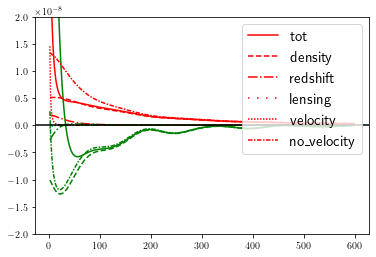

In [38]:
ells = np.arange(2, 600)

# plt.figure(figsize=(8, 5))

ls = {
    'tot':'-', 
    'density':'--', 
    'redshift':'-.',
    'lensing':(0, (1, 5)),
    'velocity':(0, (1, 1)),
#     'radial':(0, (5, 1)),
#     'timedelay':(0, (5, 10)),
#     'isw':(0, (3, 1, 1, 1)),
#     'potential':(0, (3, 1, 1, 1)),
#     'evolve':(0, (3, 1, 1, 1)),
    'no_velocity':(0, (3, 1, 1, 1)),
    
    
}

for key in ls.keys():
    plt.plot(ells, cls[key]['W2xW2'][ells], c='red', ls=ls[key], label=key)
    plt.plot(ells, cls[key]['W1xW2'][ells], c='green', ls=ls[key])
    

plt.axhline(y=0, c='k')
plt.legend(loc=1)
# plt.ylim(-0.22e-8, 1.2e-8)
plt.ylim(-2e-8, 2e-8)

# plt.xlim(0, 600)

# plt.xscale('log')

In [23]:
# set_mpl()

(0.0, 600.0)

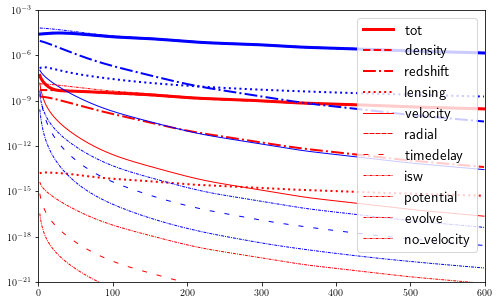

In [37]:
ells = np.arange(2, 600)

plt.figure(figsize=(8, 5))

ls = {
    'tot':'-', 
    'density':'--', 
    'redshift':'-.',
    'lensing':':',
    'velocity':'-',
    'radial':(0, (5, 1)),
    'timedelay':(0, (5, 10)),
    'isw':(0, (3, 1, 1, 1)),
    'potential':(0, (3, 1, 1, 1)),
    'evolve':(0, (3, 1, 1, 1)),
    'no_velocity':(0, (3, 1, 1, 1)),  
    
}

linewidth={
    'tot':3, 
    'density':2, 
    'redshift':2,
    'lensing':2,
    'velocity':1,
    'radial':1,
    'timedelay':1,
    'isw':1,
    'potential':1,
    'evolve':1,
    'no_velocity':1,
    
}

for key in ls.keys():
    plt.plot(ells, cls[key]['W1xW1'][ells], c='blue', ls=ls[key], linewidth=linewidth[key])
    
    plt.plot(ells, cls[key]['W2xW2'][ells], c='red', ls=ls[key], label=key, linewidth=linewidth[key])
#     plt.plot(ells, cls[key]['W1xW2'][ells], c='green', ls=ls[key])
    

# plt.axhline(y=0, c='k')
plt.legend(loc=1)
# plt.ylim(-0.22e-8, 1.2e-8)
plt.ylim(1e-21, 1e-3)

plt.semilogy()
plt.xlim(0, 600)
